In [10]:
# Importamos paquetes
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [12]:
# Hiper parámetros
batchSize = 64
epochs = 10
learningRate = 0.01
steps = 0
runningLoss = 0
printEvery = 500

Train data, number of images:  60000
Test data, number of images:  10000


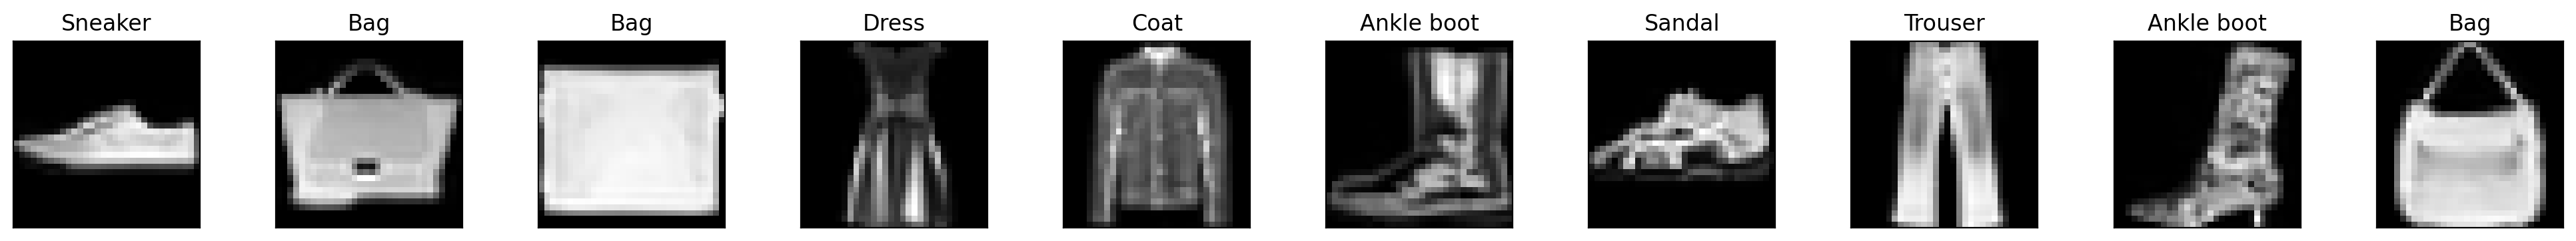

In [13]:
# Definimos una transformación de los datos
transform = transforms.Compose([transforms.Resize(32), # escalar a 32
                                transforms.ToTensor(), # convertir a tensores
                                transforms.Normalize([0.5], [0.5])]) # normalizar a media y desv std

# Descargamos el conjunto de entrenamiento y cargamos mediante un dataLoader
trainset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batchSize, shuffle=True)

# Descargamos el conjunto de validación
testset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batchSize, shuffle=True)

# Imprimir información estadística del conjunto de datos
print('Train data, number of images: ', len(trainset))
print('Test data, number of images: ', len(testset))

# Nombrar las clases de acuerdo al índice que tienen
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
# Obtener un lote de ejemplos
dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images.numpy()

displaySize = 10

# Graficar los ejemplos junto a las clases que le corresponden
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(displaySize):
    ax = fig.add_subplot(2, displaySize, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

## Arquitectura LeNet-5
<img src=https://www.datasciencecentral.com/wp-content/uploads/2021/10/1gNzz6vvWmF6tDN6pTRTd9g.jpeg>

In [14]:
# Implementación de LeNet5
class LeNet5(nn.Module):
    def __init__(self, nClases):
        # Construimos la estructura de LeNet5
        super(LeNet5, self).__init__()
        
        # self.conv1 = nn.Conv2d(1, 6, 5) # 1 canal de entrada, 6 feature maps de salida, kernels de 5x5
        # self.pool1 = nn.AvgPool2d(2, 2) # kernelsize=2, stride=2
        # self.conv2 = nn.Conv2d(6, 16, 5) # 6 canales de entrada, 16 feature maps de salida, kernels de 5x5
        # self.pool2 = nn.AvgPool2d(2, 2) # kernelsize=2, stride=2
        # self.conv3 = nn.Conv2d(16, 120, 5) # 16 canales de entrada, 120 feature maps de salida, kernels de 5x5
        
        # PoolMax
        self.conv1 = nn.Conv2d(1, 6, 5) # 1 canal de entrada, 6 feature maps de salida, kernels de 5x5
        self.pool1 = nn.MaxPool2d(2, 2) # kernelsize=2, stride=2
        self.conv2 = nn.Conv2d(6, 16, 5) # 6 canales de entrada, 16 feature maps de salida, kernels de 5x5
        self.pool2 = nn.MaxPool2d(2, 2) # kernelsize=2, stride=2
        self.conv3 = nn.Conv2d(16, 120, 5) # 16 canales de entrada, 120 feature maps de salida, kernels de 5x5
        
        # Capas totalmente conectadas
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, nClases)
    
    def forward(self, x): # Definimos el pase frontal (forward pass)
        # x = self.pool1(F.tanh(self.conv1(x)))
        # x = self.pool2(F.tanh(self.conv2(x)))
        # x = F.tanh(self.conv3(x))
        
        # x = x.view(x.size(0), -1) # Aplanamos el tensor para las capas totalmente conectadas
        # # print(x.size())
        
        # # Capas lineales
        # x = F.tanh(self.fc1(x))
        # x = self.fc2(x)
        
        # ReLu
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        
        x = x.view(x.size(0), -1) # Aplanamos el tensor para las capas totalmente conectadas
        # print(x.size())
        
        # Capas lineales
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)

In [15]:
model = LeNet5(10) # Instanciar la red
model = model.to(device=device)
criterio = nn.NLLLoss() # Definir la función de costo (criterio de optimización)
# criterio = loss_fn = nn.CrossEntropyLoss() # Definir la función de costo (criterio de optimización)
optimizer = optim.Adam(model.parameters(), lr=learningRate) # Instanciar optimizador

print(model)

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)


In [16]:
# Implementamos una función de evaluación
def validation(model, testloader, criterion):
    testLoss = 0
    accuracy = 0
    for images, labels in testloader:
        images = images.to(device=device)
        labels = labels.to(device=device)
        
        output = model.forward(images)
        testLoss += criterion(output, labels).item()

        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return testLoss, accuracy

In [17]:
# Antes del descenso por gradiente y el entrenamiento 
# verificaremos la exactitud que tiene sin haber sido entrenada.

correct = 0
total = 0
for images, labels in testloader:
    images = images.to(device=device)
    labels = labels.to(device=device)
        
    images = Variable(images)
    outputs = model.forward(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
accuracy = 100 * correct.cpu().numpy() / total

print("Porcentaje de exactitud antes de entrenar:", accuracy)

Porcentaje de exactitud antes de entrenar: 11.34


In [18]:
# Descenso por gradiente
for epoch in range(epochs):
    model.train()  # Cambiamos a modo de entrenamiento
    for images, labels in trainloader:
        steps += 1
        optimizer.zero_grad()
        
        images = images.to(device=device)
        labels = labels.to(device=device)
        
        images, labels = Variable(images), Variable(labels)       
        
        output = model.forward(images)
        loss = criterio(output, labels)
        loss.backward() # Backpropagation
        optimizer.step() # Optimización
        
        runningLoss += loss.item()
        
        if steps % printEvery == 0:
            model.eval() # Cambiamos a modo de evaluación
            
            # Apagamos los gradientes, reduce memoria y cálculos
            with torch.no_grad():
                testLoss, accuracy = validation(model, testloader, criterio)
                
            print("Epoch: {}/{}.. ".format(epoch+1, epochs),
                  "Training Loss: {:.3f}.. ".format(runningLoss/printEvery),
                  "Test Loss: {:.3f}.. ".format(testLoss/len(testloader)),
                  "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
            
            runningLoss = 0
            model.train() # Regresamos a modo de entrenamiento

Epoch: 1/10..  Training Loss: 0.604..  Test Loss: 0.477..  Test Accuracy: 0.826
Epoch: 2/10..  Training Loss: 0.436..  Test Loss: 0.435..  Test Accuracy: 0.845
Epoch: 2/10..  Training Loss: 0.387..  Test Loss: 0.392..  Test Accuracy: 0.865
Epoch: 3/10..  Training Loss: 0.383..  Test Loss: 0.404..  Test Accuracy: 0.855
Epoch: 3/10..  Training Loss: 0.355..  Test Loss: 0.396..  Test Accuracy: 0.862
Epoch: 4/10..  Training Loss: 0.353..  Test Loss: 0.362..  Test Accuracy: 0.869
Epoch: 4/10..  Training Loss: 0.344..  Test Loss: 0.345..  Test Accuracy: 0.879
Epoch: 5/10..  Training Loss: 0.343..  Test Loss: 0.387..  Test Accuracy: 0.869
Epoch: 5/10..  Training Loss: 0.363..  Test Loss: 0.373..  Test Accuracy: 0.869
Epoch: 6/10..  Training Loss: 0.342..  Test Loss: 0.384..  Test Accuracy: 0.866
Epoch: 6/10..  Training Loss: 0.336..  Test Loss: 0.375..  Test Accuracy: 0.874
Epoch: 7/10..  Training Loss: 0.316..  Test Loss: 0.372..  Test Accuracy: 0.875
Epoch: 7/10..  Training Loss: 0.321..  T

C:\Users\leoll\AppData\Local\Temp\ipykernel_3764\3237490966.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  preds = np.squeeze(model(Variable(images, volatile=True)).data.max(1, keepdim=True)[1].cpu().numpy())


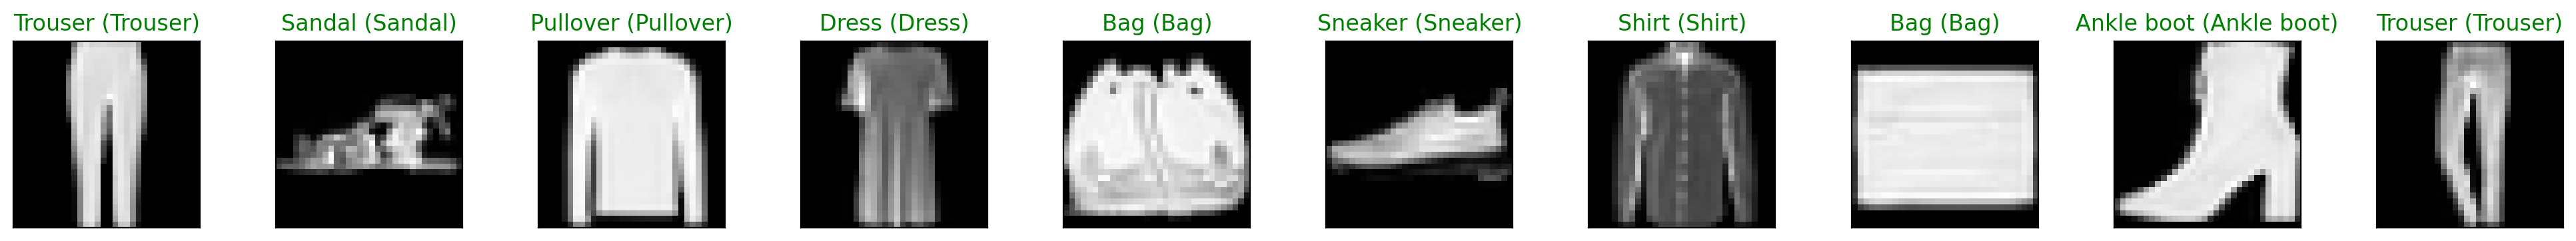

In [19]:
dataiter = iter(testloader)
images, labels = next(dataiter)

images = images.to(device=device)
labels = labels.to(device=device)
        
# get predictions
preds = np.squeeze(model(Variable(images, volatile=True)).data.max(1, keepdim=True)[1].cpu().numpy())
images = images.cpu().numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(displaySize):
    ax = fig.add_subplot(2, displaySize, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx] else "red"))